# BERTopic-Driven Stock Market Predictions: Unraveling Sentiment Insights
## Reproduction de la méthodologie du papier scientifique

**Objectif** : Reproduire l'approche du papier qui utilise BERTopic pour extraire des topics 
des commentaires boursiers, analyser leur sentiment, et intégrer ces features dans des 
modèles de deep learning pour améliorer la prédiction des prix des actions.

**Dataset** : Tweets pour 27 actions avec données boursières associées
**Période** : À définir selon vos données
**Modèles testés** : LSTM, CNN, CNN-LSTM, GAN
**Sentiment** : BERT et VADER

***Import des librairies***

In [1]:
# Installation et imports de toutes les bibliothèques nécessaires
# Inclure : pandas, numpy, sklearn, tensorflow/keras, transformers, bertopic, 
# vader, umap, hdbscan, sentence-transformers, matplotlib, seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Attempt to import advanced models
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    USE_FINBERT = True
except ImportError:
    USE_FINBERT = False

try:
    from bertopic import BERTopic
    from sentence_transformers import SentenceTransformer
    import umap
    import hdbscan
    USE_BERTOPIC = True
except ImportError:
    USE_BERTOPIC = False

# Ensure NLTK data is downloaded
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to C:\Users\Juan David
[nltk_data]     Alonso\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

**SECTION 1 : Chargement et Exploration des Données**

***Chargement des données tweets***

***Chargement des données boursières***

In [7]:
# Charger le dataset contenant les tweets pour les 27 actions
# Colonnes attendues : Date, Tweet, Stock Name, Company Name
# Vérifier la structure du dataset et afficher les premières lignes
#Charger les données de marché (prix, volume) pour les 27 actions
# Colonnes attendues : Date, Open, High, Low, Close, Adj Close, Volume, Stock Name
# Vérifier la correspondance des dates entre tweets et données boursières
# Paths 
tweets_path = 'data/stock_tweets.csv'
prices_path = 'data/stock_yfinance_data.csv'

# Charger tweets et price data
tweets_df = pd.read_csv(tweets_path)
prices_df = pd.read_csv(prices_path)

# basic info
print('Tweets shape:', tweets_df.shape)
print('Price shape:', prices_df.shape)

Tweets shape: (80793, 4)
Price shape: (6300, 8)


***Analyse exploratoire des tweets***

Nombre de tweets par action :
   Stock Name  Nombre de tweets
0        AAPL              5056
1         AMD              2227
2        AMZN              4089
3          BA               399
4          BX                50
5        COST               393
6         CRM               233
7         DIS               635
8        ENPH               216
9           F                31
10       GOOG              1291
11       INTC               315
12         KO               310
13       META              2751
14       MSFT              4089
15       NFLX              1727
16        NIO              3021
17        NOC                31
18         PG              4089
19       PYPL               843
20       TSLA             37422
21        TSM             11034
22         VZ               123
23       XPEV               225
24         ZS               193


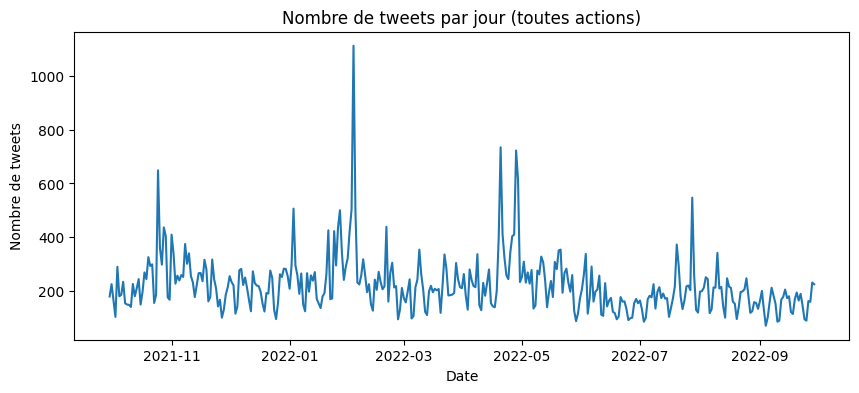

Longueur moyenne des tweets: 27.38 mots
Longueur moyenne des tweets par action :
   Stock Name  Longueur moyenne
0        AAPL         30.097508
1         AMD         33.413112
2        AMZN         31.971142
3          BA         36.994987
4          BX         37.600000
5        COST         32.646310
6         CRM         34.849785
7         DIS         28.344882
8        ENPH         37.111111
9           F         33.516129
10       GOOG         31.272657
11       INTC         33.663492
12         KO         37.806452
13       META         30.412941
14       MSFT         31.971142
15       NFLX         28.521135
16        NIO         24.535584
17        NOC         33.516129
18         PG         31.971142
19       PYPL         32.722420
20       TSLA         26.783470
21        TSM         18.874932
22         VZ         40.365854
23       XPEV         32.208889
24         ZS         41.077720


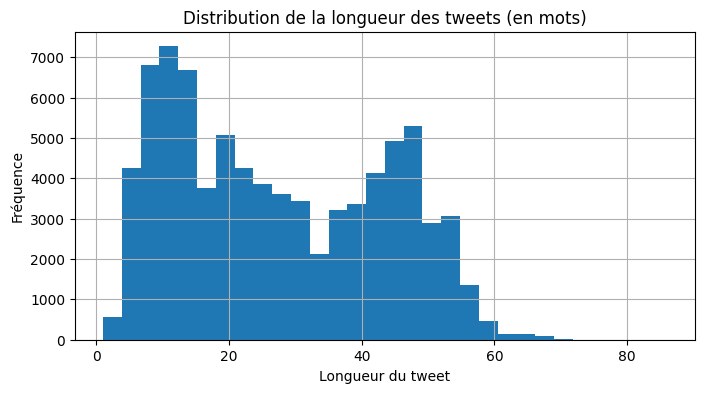

In [9]:
#Statistiques descriptives sur les tweets
# - Nombre de tweets par action
# - Distribution temporelle des tweets
# - Longueur moyenne des tweets
# - Visualisations (histogrammes, time series)


# Statistiques descriptives sur les tweets

# Nombre de tweets par action
compte_tweets = tweets_df.groupby('Stock Name')['Tweet'].count().reset_index().rename(columns={'Tweet': 'Nombre de tweets'})
print("Nombre de tweets par action :")
print(compte_tweets)

# Distribution temporelle des tweets
# Convertir les dates des tweets en date (si ce n'est pas déjà fait)
tweets_df['date_only'] = pd.to_datetime(tweets_df['Date'], utc=True).dt.date
distribution_temporelle = tweets_df.groupby('date_only')['Tweet'].count()

plt.figure(figsize=(10,4))
distribution_temporelle.plot(kind='line')
plt.title("Nombre de tweets par jour (toutes actions)")
plt.xlabel("Date")
plt.ylabel("Nombre de tweets")
plt.show()

# Longueur moyenne des tweets (en mots)
tweets_df['longueur'] = tweets_df['Tweet'].astype(str).apply(lambda x: len(x.split()))
longueur_moyenne_globale = tweets_df['longueur'].mean()
print(f"Longueur moyenne des tweets: {longueur_moyenne_globale:.2f} mots")
longueur_moyenne_action = tweets_df.groupby('Stock Name')['longueur'].mean().reset_index().rename(columns={'longueur': 'Longueur moyenne'})
print("Longueur moyenne des tweets par action :")
print(longueur_moyenne_action)

# Histogramme de la longueur des tweets
plt.figure(figsize=(8,4))
tweets_df['longueur'].hist(bins=30)
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Longueur du tweet")
plt.ylabel("Fréquence")
plt.show()

***Analyse exploratoire des données boursières***

In [89]:
#Statistiques descriptives sur les prix
# - Évolution des prix (Close) pour quelques actions
# - Distribution des volumes
# - Volatilité par action

**SECTION 2 : Prétraitement des Tweets**

***Nettoyage des tweets***

In [90]:
# Prétraitement du texte des tweets
# - Suppression des URLs, mentions (@), hashtags si nécessaire
# - Suppression des caractères spéciaux
# - Conversion en minuscules (optionnel selon la méthode)
# - Gestion des emojis (VADER les utilise, donc les conserver)
# Note : Le papier utilise VADER qui gère bien les emojis et la ponctuation

***Filtrage par action***

In [91]:
# Organiser les tweets par action (Stock Name)
# Créer une structure permettant de traiter chaque action séparément
# Exemple : dictionnaire {stock_name: list_of_tweets}

In [10]:
# Prétraiter les dates et filtrer pour une action spécifique (par ex., Amazon)

# Choisir le symbole de l'action
TARGET_TICKER = 'AMZN'

# Convertir les horodatages des tweets en datetime (UTC) et extraire la date
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], utc=True)
tweets_df['date_only'] = tweets_df['Date'].dt.date

# Filtrer les tweets pour l'action cible
stock_tweets = tweets_df[tweets_df['Stock Name'] == TARGET_TICKER].copy()

# Fonction de nettoyage de base pour les tweets
def clean_text(text: str) -> str:
# Mettre en minuscules, supprimer les URL et les caractères non alphanumériques
    import re
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

stock_tweets['clean_tweet'] = stock_tweets['Tweet'].astype(str).apply(clean_text)

print('Number of tweets for', TARGET_TICKER, ':', len(stock_tweets))

Number of tweets for AMZN : 4089


**SECTION 3: Extraction des Topics avec BERTopic**

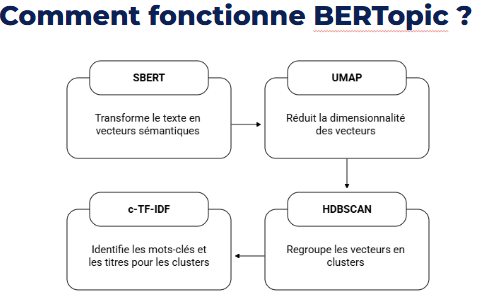

***Préparation des embeddings avec Sentence-BERT***

In [92]:
# Utilisation de Sentence-BERT (SBERT) pour générer les embeddings
# - Charger le modèle sentence-transformers (ex: 'all-MiniLM-L6-v2')
# - Générer les embeddings pour tous les tweets
# - Ces embeddings capturent la sémantique complète de chaque tweet

***Réduction de dimension avec UMAP***

In [93]:
#Réduire la dimensionnalité des embeddings avec UMAP
# - UMAP évite la "malédiction de la dimensionnalité" pour le clustering
# - Paramètres : n_neighbors, n_components, metric
# - Préserver la structure sémantique locale et globale

***Clustering avec HDBSCAN***

In [94]:
# Appliquer HDBSCAN pour regrouper les tweets en topics
# - HDBSCAN est basé sur la densité (pas de K à définir a priori)
# - Identifie automatiquement le nombre de clusters
# - Détecte les outliers (tweets n'appartenant à aucun topic clair)
# - Paramètres : min_cluster_size, min_samples

***Génération des représentations de topics avec c-TF-IDF***

In [95]:
#Créer les représentations textuelles des topics
# - Fusionner tous les documents d'un même cluster
# - Calculer c-TF-IDF pour identifier les mots-clés de chaque topic
# - Formule : c-TF-IDF(t,c) = TF(t,c) × log(N / (1 + DF(t)))
# - Extraire les top-N mots les plus représentatifs par topic

***Analyse et visualisation des topics***

In [96]:
#Explorer les topics découverts
# - Afficher les mots-clés pour chaque topic
# - Visualiser la distribution des topics (nombre de tweets par topic)
# - Créer une visualisation 2D des topics (UMAP)
# - Interpréter les thèmes : sont-ils cohérents avec le domaine boursier ?

**SECTION 4: Analyse de sentiment**

***Sentiment avec VADER (sur les tweets bruts)***

In [97]:
# Appliquer VADER pour obtenir le sentiment de chaque tweet
# - VADER est adapté aux textes courts et aux réseaux sociaux
# - Il gère : négations, intensificateurs, ponctuation, emojis, majuscules
# - Sortie : compound score entre -1 (très négatif) et +1 (très positif)
# - Catégoriser : Positive, Neutral, Negative selon des seuils

***Agrégation du sentiment VADER par jour et par action***

In [98]:
#Calculer le score de sentiment moyen quotidien par action
# - Grouper les tweets par (Date, Stock Name)
# - Calculer la moyenne pondérée des scores de sentiment
# - Créer une colonne 'score' dans le dataset boursier
# - Cette colonne représente le sentiment global quotidien

***Sentiment avec BERT (sur les tweets bruts)***

In [99]:
#Utiliser un modèle BERT fine-tuné pour l'analyse de sentiment
# - Modèle recommandé : 'nlptown/bert-base-multilingual-uncased-sentiment'
#   ou 'ProsusAI/finbert' (spécialisé finance)
# - Obtenir un score de sentiment pour chaque tweet
# - Normaliser les scores entre -1 et +1

***Agrégation du sentiment BERT par jour et par action***

In [100]:
#Calculer le score de sentiment BERT moyen quotidien par action
# - Même logique que pour VADER
# - Créer une colonne 'score_bert' dans le dataset boursier

**SECTION 5 : Sentiment des Topics**

***Attribution des topics aux tweets***

In [101]:
#Associer chaque tweet à son topic identifié par BERTopic
# - Ajouter une colonne 'topic_id' au dataframe des tweets
# - Gérer les outliers (topic = -1) : les exclure ou traiter séparément

***Calcul du sentiment des topics avec VADER***

In [102]:
# Pour chaque tweet, obtenir le sentiment du topic auquel il appartient
# - Méthode 1 : Sentiment moyen de tous les tweets d'un même topic
# - Méthode 2 : Sentiment de la représentation textuelle du topic (mots-clés)
# - Le papier semble utiliser la méthode 1
# - Créer une colonne 'topic_sentiment_vader'

***Calcul du sentiment des topics avec BERT***

In [103]:
#Même approche mais avec BERT
# - Calculer le sentiment moyen BERT pour chaque topic
# - Créer une colonne 'topic_sentiment_bert'

***Agrégation du sentiment des topics par jour et par action***

In [104]:
#Créer les colonnes 'score_topic_vader' et 'score_topic_bert'
# - Pour chaque (Date, Stock Name), calculer la moyenne des sentiments des topics
# - Ces colonnes seront des features supplémentaires dans les modèles

**SECTION 6 : Calcul des Indicateurs Techniques**

***Moyennes mobiles (MA7, MA20)***

In [105]:
# Calculer les moyennes mobiles sur 7 et 20 jours
# - MA7 : moyenne du Close sur les 7 derniers jours
# - MA20 : moyenne du Close sur les 20 derniers jours
# - Ces indicateurs capturent les tendances court et moyen terme

***MACD (Moving Average Convergence Divergence)***

In [106]:
#Calculer le MACD
# - EMA 12 jours et EMA 26 jours
# - MACD = EMA12 - EMA26
# - Indicateur de momentum qui montre la relation entre deux moyennes mobiles

***Bandes de Bollinger***

In [107]:
#Calculer les Bandes de Bollinger
# - 20SD : écart-type du Close sur 20 jours (volatilité)
# - upper_band = MA20 + (2 × 20SD)
# - lower_band = MA20 - (2 × 20SD)
# - Indicateurs de volatilité et de surachat/survente

***EMA et Log Momentum***

In [108]:
#Calculer l'EMA et le log momentum
# - EMA : moyenne mobile exponentielle (plus de poids sur les données récentes)
# - log_momentum = log(Close_t / Close_{t-n})
# - Momentum : différence entre prix actuel et prix il y a N jours

***Consolidation du dataset final***

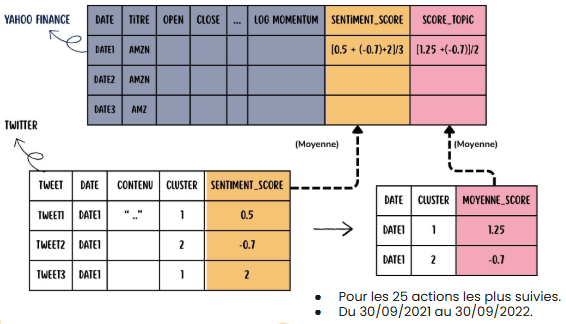

In [109]:
#Créer le dataset complet avec toutes les features
# - Fusionner données boursières + indicateurs techniques + scores de sentiment
# - Colonnes finales : Date, Open, High, Low, Close, Adj Close, Volume, 
#   MA7, MA20, MACD, 20SD, upper_band, lower_band, EMA, log_momentum,
#   score (VADER global), score_bert (BERT global),
#   score_topic_vader, score_topic_bert, Stock Name
# - Gérer les valeurs manquantes (NaN) dues aux fenêtres de calcul

**SECTION 7 : Préparatin des données pour le Machine Learning**

***Sélection d'une action pour les expériences***

In [110]:
#Pour reproduire le papier, sélectionner Amazon (AMZN)
# - Filtrer le dataset pour ne garder que AMZN
# - Le papier montre les résultats sur AMZN, on reproduira cela
# - Par la suite, on pourra itérer sur les 27 actions

***Split Train/Test***

In [111]:
#Diviser les données en ensemble d'entraînement et de test
# - Le papier utilise : train = toutes les données sauf les 20 derniers jours
# - Test = les 20 derniers jours
# - Respecter l'ordre chronologique (pas de shuffle)

***Normalisation avec MinMaxScaler***

In [112]:
#Normaliser les features numériques
# - Appliquer MinMaxScaler sur Adj Close séparément (comme dans le papier)
# - Puis appliquer MinMaxScaler sur l'ensemble du dataset
# - Sauvegarder les scalers pour l'inversion lors de l'évaluation
# - La normalisation améliore la convergence des réseaux de neurones

***Préparation des séquences pour LSTM***

In [113]:
#Créer des séquences temporelles pour LSTM
# - Fenêtre temporelle (time steps) : à définir (ex: 60 jours), [PAS DIT DANS LE PAPIER]
# - Pour chaque sample, prendre les N derniers jours comme input
# - La target est le Adj Close du jour suivant
# - Format : (n_samples, time_steps, n_features)

**SECTION 8 : BASELINE (sans sentiment)**


_______________FAIRE UN COURT TEXTE POUR EXPLIQUER L'ABADON DU MODELE GAN__________

***LSTM - Baseline***

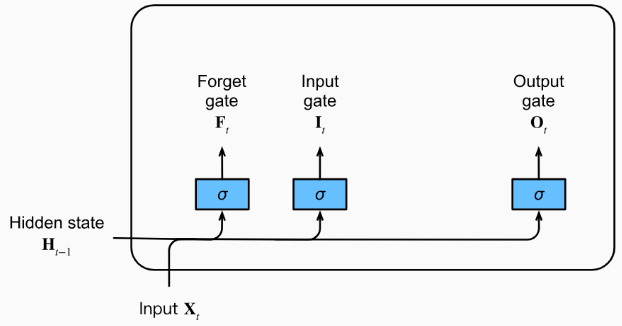

In [114]:
#Construire et entraîner un modèle LSTM sans features de sentiment
# - Architecture : LSTM(50 units, relu) + Dense(1)
# - Input features : Open, High, Low, Close, Volume, MA7, MA20, MACD, etc.
#   (SANS score, score_topic)
# - Optimizer : Adam
# - Loss : MSE
# - Epochs : 200
# - Entraîner sur le train set

***Évaluation LSTM Baseline***

In [115]:
#Évaluer les performances du LSTM Baseline
# - Prédictions sur train et test sets
# - Calculer : RMSE, MAE, R², MAPE
# - Visualiser : courbes de prédiction vs réalité (train et test)
# - Visualiser : courbe de loss pendant l'entraînement

***CNN - Baseline***
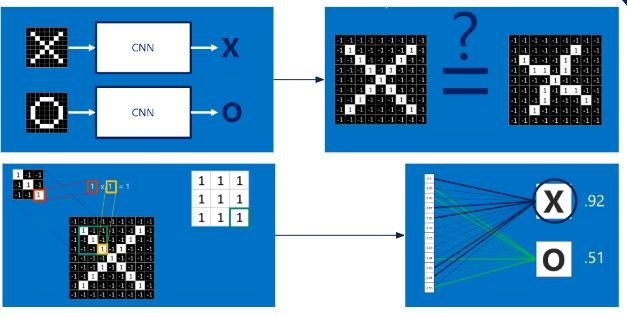

In [116]:
# Construire et entraîner un modèle CNN sans features de sentiment
# - Architecture : Conv1D(64 filters, kernel=2, relu) + MaxPooling1D(2) 
#   + Flatten + Dense(50, relu) + Dense(1)
# - Mêmes features d'input que LSTM Baseline
# - Optimizer : Adam, Loss : MSE, Epochs : 200

***Évaluation CNN Baseline***

In [117]:
# Évaluer CNN Baseline (mêmes métriques que LSTM)

***CNN-LSTM - Baseline***

In [118]:
#Construire un modèle hybride CNN-LSTM sans sentiment
# - Architecture : Conv1D(64, 2, relu) + LSTM(50, relu) + Dense(1)
# - Le CNN extrait des features spatiales, le LSTM capture les dépendances temporelles
# - Mêmes paramètres d'entraînement

***Évaluation CNN-LSTM Baseline***

In [119]:
# Évaluer CNN-LSTM Baseline

**SECTION 9 :Expériences - Avec Sentiment GLOBAL (sans topics)**

***LSTM + Sentiment VADER (sans topics)***

In [120]:
#LSTM avec ajout du score de sentiment VADER global
# - Input features : features Baseline + score (VADER)
# - Même architecture que Baseline

***LSTM + Sentiment BERT (sans topics)***

In [121]:
#LSTM avec ajout du score de sentiment BERT global
# - Input features : features Baseline + score_bert

***Répéter pour CNN, CNN-LSTM***

In [122]:
####

***Évaluation par rapport à la baseline***

In [123]:
#Évaluer et comparer avec Baseline pour chaque modèle

**SECTION 10: Expériences - Avec Sentiment des TOPICS**

***LSTM + Sentiment VADER des Topics***

In [124]:
#LSTM avec ajout du score de sentiment des topics (VADER)
# - Input features : features Baseline + score_topic_vader
# - Cette expérience teste l'hypothèse clé du papier :
#   le sentiment des topics améliore significativement les prédictions

***LSTM + Sentiment BERT des Topics***

In [125]:
#Pareil LSTM mais avec score_topic_bert

***Répéter pour CNN, CNN-LSTM***

In [126]:
###

***Évaluation par rapport à la baseline/sentiment global***

In [127]:
###
# LSTM :Le papier montre une amélioration ~10% des métriques quand on ajoute les topics
#Le papier montre que CNN-LSTM + topics donne les meilleures performances sur tout les méthodes

**SECTION 11: Comparaison Globale des Résultats**

***Tableau récapitulatif des performances***

In [128]:
#Créer un DataFrame consolidant toutes les métriques
# - Lignes : tous les modèles testés (Baseline, +sentiment, +topics)
# - Colonnes : RMSE, MAE, R², MAPE (train et test)
# - Reproduire les Tableaux III, IV, V, VI, VII du papier

***Visualisations comparatives***

In [129]:
#Créer des graphiques pour comparer les modèles
# - Bar plots pour RMSE, MAE, R², MAPE
# - Heatmap des performances
# - Highlight : amélioration apportée par le sentiment des topics

***Analyse statistique***

In [130]:
#Tester la significativité des améliorations
# - Tests statistiques (t-test) pour vérifier si l'amélioration est significative
# - Calculer les pourcentages d'amélioration

**SECTION 12 : Extension aux 27 Actions**

***Pipeline automatisé pour toutes les actions***

In [131]:
#Créer une fonction qui applique tout le pipeline à une action
# - Input : stock_name
# - Output : métriques de performance pour tous les modèles
# - Permet de reproduire les expériences sur les 27 actions

***Exécution sur les 27 actions***

In [132]:
# Boucler sur les 27 actions et collecter les résultats
# - Attention : cela peut prendre plusieurs heures
# - Sauvegarder les résultats intermédiaires

***Analyse multi-actions***

In [133]:
#Analyser les performances agrégées
# - Moyenne des métriques sur les 27 actions
# - Identifier les actions pour lesquelles le sentiment des topics est le plus impactant
# - Corréler avec la volatilité, le volume, etc.

**SECTION 13 : Analyse Qualitatives des Topics**

***Interprétation des topics***

In [134]:
#Analyser qualitativement les topics découverts
# - Quels sont les thèmes principaux discutés pour chaque action ?
# - Y a-t-il des topics communs à plusieurs actions ?
# - Exemples de tweets représentatifs pour chaque topic

***Évolution temporelle des topics***

In [135]:
#Visualiser comment les topics évoluent dans le temps
# - Time series du nombre de tweets par topic
# - Corrélation entre l'émergence d'un topic et les mouvements de prix

***Topics et sentiment**

In [136]:
#Analyser la polarité des topics
# - Quels topics sont systématiquement positifs/négatifs ?
# - Relation entre type de topic et impact sur le prix

**SECTION 14 : Limites et améliorations possibles**

***Discussion des limites***

In [137]:
# Identifier les limites de l'approche
# - Qualité et représentativité des tweets (biais d'échantillonnage)
# - Période d'étude limitée (1 an)
# - Topics non supervisés : pas de garantie de pertinence
# - VADER et BERT peuvent manquer des nuances (sarcasme, contexte financier)
# - Pas de prise en compte d'autres sources d'information (news, reports)

***Pistes d'amélioration***

In [138]:
# Commentaire : Proposer des extensions
# - Analyse en temps réel
# - Intégration de données multi-sources (Twitter + Reddit + news)
# - Fine-tuning de BERT sur le domaine financier  ---> FinTWitterBERT à tester?
# - Modèles d'attention (Transformers) pour capturer les dépendances
# - Prise en compte des émotions (peur, euphorie) au-delà du sentiment
# - Analyse de causalité (Granger) entre sentiment et prix

**SECTION 15 : Conclusion**

***Résumé des résultats***

In [139]:
# Commentaire : Synthèse des findings
# - Le sentiment des topics extrait par BERTopic améliore significativement la prédiction
# - CNN-LSTM + sentiment des topics : meilleure architecture
# - VADER et BERT donnent des résultats comparables
# - L'information implicite des discussions en ligne est exploitable

***Implications pratiques***

In [140]:
# pplications potentielles
# - Outils d'aide à la décision pour traders
# - Systèmes d'alerte basés sur le sentiment
# - Stratégies de trading algorithmique
# - Nécessité de combiner avec d'autres analyses (fondamentale, technique)

**SECTION 16 : Annexes (si besoin)**

***Fonctions utilitaires***

In [141]:
# Commentaire : Regrouper toutes les fonctions réutilisables
# - Fonctions de preprocessing
# - Fonctions de calcul d'indicateurs techniques
# - Fonctions de création de modèles
# - Fonctions d'évaluation

***Sauvegarde des modèles et résultats***

In [142]:
#Sauvegarder les modèles entraînés et les résultats
# - Pickle ou HDF5 pour les modèles Keras
# - CSV pour les tableaux de résultats
# - JSON pour les configurations